In [1]:
import bz2
import json
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [47]:
# If working on colab :
from google.colab import drive
drive.mount('/content/drive') 

data_path = '/content/drive/MyDrive/'

In [2]:
# If working locally :
data_path = ''

# Initial methods given 

### Example of how to work with the quotes data file

In [3]:
from tld import get_tld

def get_domain(url):
    res = get_tld(url, as_object=True)
    return res.tld

In [4]:
path_to_file = 'Quotebank/quotes-2020.json.bz2' 
path_to_out = 'data/quotes-2020-domains.json.bz2'

with bz2.open(path_to_file, 'rb') as s_file:
    with bz2.open(path_to_out, 'wb') as d_file:
        for instance in s_file:
            instance = json.loads(instance) # loading a sample
            urls = instance['urls'] # extracting list of links
            domains = []
            for url in urls:
                tld = get_domain(url)
                domains.append(tld)
            instance['domains'] = domains # updating the sample with domain name
            d_file.write((json.dumps(instance)+'\n').encode('utf-8')) # writing in the new file

### Load the speaker_attributes parquet file

In [5]:
speaker_attributes = pd.read_parquet(data_path+'Project datasets/speaker_attributes.parquet')

In [6]:
speaker_attributes.head()

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
0,"[Washington, President Washington, G. Washingt...",[+1732-02-22T00:00:00Z],"[Q161885, Q30]",[Q6581097],1395141751,None,W000178,"[Q82955, Q189290, Q131512, Q1734662, Q294126, ...",[Q327591],None,Q23,George Washington,"[Q698073, Q697949]",item,[Q682443]
1,"[Douglas Noel Adams, Douglas Noël Adams, Dougl...",[+1952-03-11T00:00:00Z],[Q145],[Q6581097],1395737157,[Q7994501],None,"[Q214917, Q28389, Q6625963, Q4853732, Q1884422...",None,None,Q42,Douglas Adams,None,item,None
2,"[Paul Marie Ghislain Otlet, Paul Marie Otlet]",[+1868-08-23T00:00:00Z],[Q31],[Q6581097],1380367296,None,None,"[Q36180, Q40348, Q182436, Q1265807, Q205375, Q...",None,None,Q1868,Paul Otlet,None,item,None
3,"[George Walker Bush, Bush Jr., Dubya, GWB, Bus...",[+1946-07-06T00:00:00Z],[Q30],[Q6581097],1395142029,None,None,"[Q82955, Q15982858, Q18814623, Q1028181, Q1408...",[Q29468],None,Q207,George W. Bush,"[Q327959, Q464075, Q3586276, Q4450587]",item,"[Q329646, Q682443, Q33203]"
4,"[Velázquez, Diego Rodríguez de Silva y Velázqu...",[+1599-06-06T00:00:00Z],[Q29],[Q6581097],1391704596,None,None,[Q1028181],None,None,Q297,Diego Velázquez,None,item,None


### Load the labels descriptions for quotebank

In [7]:
label_description = pd.read_csv(data_path+'Project datasets/wikidata_labels_descriptions_quotebank.csv.bz2', compression='bz2', index_col='QID')

In [8]:
label_description.head()

,Label,Description
QID,,
Q31,Belgium,country in western Europe
Q45,Portugal,country in southwestern Europe
Q75,Internet,global system of connected computer networks
Q148,People's Republic of China,sovereign state in East Asia
Q155,Brazil,country in South America


# Dealing with the features

In order to answer our research questions we will not need all the initial features of the quotebank datasets. Thus we decided to keep the following ones:

*   **date**: Because we will work with specific periods.
*   **numOccurences**: To have a better insight about quotations and potential bias in our analysis.
*   **qids**: This is the speakers'id, necessary to be able to pair with the speaker_attributes data.
*   **quotation**: Obviously to perform sentiment analysis.
*   **quoteID**: To identify the quotes.
*   **speaker**: To access their attributes and see if there's multiple qids for the same speaker. /!\

For the 3 remaining features, we explain why we decided to drop them out:

* **phase**

Described here : [description of the phase](https://github.com/epfl-dlab/Quotebank/blob/main/phases.md). All of quotations we will use initially are from phase E (2015-2020) as they are past June 2014. If we need to work with older dates, we could refer on the date feature which should be enough.

We do a little check below :

In [7]:
count_E = 0
count_quote = 0
quotes = bz2.open(data_path+'Quotebank/quotes-2020.json.bz2', 'rb')

for instance in quotes:
    quote = json.loads(instance) # loading a sample
    phase = quote['phase'] # extracting list of links
    if phase == 'E':
        count_E += 1
    count_quote+=1

In [8]:
print(f'We have {count_E*100/count_quote}% of quotes in phase E for 2020')

We have 100.0% of quotes in phase E for 2020


As expected, we don't have any other phase than phase 'E' in the dataset from 2020. We shouldn't have them for 2015-2019. With the test on 2020 and the description's informations, we decided that it safe to drop this feature.

* #### probas

We only keep the main speaker, therefore the probabilities and name of the other speakers are not useful for us. We chose to rely on the decisions made by QuoteBank in choosing the speaker, and only keep the main(s) one(s).

* #### Urls

In our research, we don't specificaly look into the source of the quote, expect for the speaker. Therefore, we decided to drop the urls feature as it should be irrevelant for our project.

### Dropping the unwanted features

Here we only keep the features we need as described previously.

In [9]:
def drop_features(path_to_file, path_to_out, max_instances=-1):
    count = 0
    with bz2.open(path_to_file, 'rb') as s_file:
        with bz2.open(path_to_out, 'wb') as d_file:
            for instance in s_file:
                if count == max_instances:
                    return
                instance = json.loads(instance)  # loading a sample
                series = pd.Series(instance)
                instance = series[[
                    'quoteID',
                    'date',
                    'numOccurrences',
                    'qids',
                    'quotation',
                    'speaker',
                    ]].to_dict()
                d_file.write((json.dumps(instance) + '\n').encode('utf-8'))  # writing in the new file
                count += 1

Small test with the 100 first instances:

In [10]:
path_to_file = data_path+'Quotebank/quotes-2020.json.bz2'
path_to_out = data_path+'data/quotes-2020-dropped-features.json.bz2'

drop_features(path_to_file, path_to_out, 100)

dropped_features_df = pd.read_json(path_to_out, compression='bz2', lines=True)
dropped_features_df.head()

,quoteID,date,numOccurrences,qids,quotation,speaker
0,2020-01-28-000082,2020-01-28 08:04:05,1,[],[ D ] espite the efforts of the partners to cr...,None
1,2020-01-16-000088,2020-01-16 12:00:13,1,[Q367796],[ Department of Homeland Security ] was livid ...,Sue Myrick
2,2020-02-10-000142,2020-02-10 23:45:54,1,[],... He (Madhav) also disclosed that the illega...,None
3,2020-02-15-000053,2020-02-15 14:12:51,2,[],"... [ I ] f it gets to the floor,",None
4,2020-01-24-000168,2020-01-24 20:37:09,4,[Q20684375],[ I met them ] when they just turned 4 and 7. ...,Meghan King Edmonds


### Special case: when we need to have the speaker's information

For some of the questions we plan to answer, see the [readMe.md](https://github.com/epfl-ada/ada-2021-project-abracadabra/blob/main/README.md), we need to access the speaker's attributes. If we don't have any informations concerning them, we will not use the quote for our research. Thus we can also process the data to create one containing only the quotes that have a defined speaker.

In [12]:
quotes = bz2.open(data_path+'Quotebank/quotes-2020.json.bz2', 'rb')
count_none = 0
for instance in quotes:
    quote = json.loads(instance)  # loading a sample
    speaker = quote['speaker']  # extracting list of links
    if speaker == 'None':
        count_none += 1
print(count_none)

1800844


In [70]:
print(f'There is {count_none*100/count_quote}% of speakers defined as None')

There is 34.338097291059555% of speakers defined as None


As we see, on the quotebank data of 2020 we already have ~34% of missing speaker, labelled as "None". Therefore, we can remove those quotes keep the other in a new Json file.

To further justify this choice, let's take a look at the exemple below :

In [17]:
## Load a sample quote
quotes = bz2.open(data_path+'Quotebank/quotes-2020.json.bz2', 'rb')
samples = 0
quote = ''
for q in quotes:
    if samples == 1:
        break
    quote = json.loads(q)
    samples += 1
quote

{'quoteID': '2020-01-28-000082',
 'quotation': '[ D ] espite the efforts of the partners to create a non-political award that unites the Jewish people, some have incorrectly interpreted the participation of the Office of the Prime Minister in the Genesis Prize as bringing a political dimension to this important initiative,',
 'speaker': 'None',
 'qids': [],
 'date': '2020-01-28 08:04:05',
 'numOccurrences': 1,
 'probas': [['None', '0.7272'],
  ['Prime Minister Netanyahu', '0.2445'],
  ['Natan Sharansky', '0.0283']],
 'urls': ['http://israelnationalnews.com/News/News.aspx/275210'],
 'phase': 'E'}

In this particular quote, it is ~73% sure of not knowing who is the right speaker. We could decide that the speaker is the 
```
['Prime Minister Netanyahu', '0.2445']
```
but there is more chance of it being false as it has only ~24% of chances of being him. We prefer to take only the speakers with an high chance of being right.

In [18]:
def drop_unknown_speaker(path_to_file, path_to_out, max_instances=-1):
    count = 0
    with bz2.open(path_to_file, 'rb') as s_file:
        with bz2.open(path_to_out, 'wb') as d_file:
            for instance in s_file:
                if count == max_instances:
                    return
                instance = json.loads(instance)  # loading a sample
                speaker = instance['speaker']
                if speaker != 'None':
                    d_file.write((json.dumps(instance) + '\n').encode('utf-8'))  # writing in the new file
                count += 1

Here we only work on 100 000 instances to fasten the test part:

In [19]:
path_to_file = data_path+'Quotebank/quotes-2020.json.bz2'
path_to_out = data_path+'data/quotes-2020-dropped_unknown_speaker.json.bz2'

drop_unknown_speaker(path_to_file, path_to_out, 100000)

dropped_unknown_speaker_df = pd.read_json(path_to_out, compression='bz2', lines=True)

print(dropped_unknown_speaker_df.loc[dropped_unknown_speaker_df.speaker == 'None', 'speaker'].count())

0


Sine we took out all the 'None' speaker from the original data, we now have a lighter and more precise one to work with for some of our analysis.

# Data analysis

## Dates

Since we will be working a lot with dates, it is great to have better insights about them, for example their distributions.
As the dates are in the format 'yyyy-mm-dd hh:mm:ss', we check that all the dates are well in 2020 by checking the first 4 characters. Doing so helps us to check if there's any date which is not correctly written or missing:

In [24]:
quotes = bz2.open(data_path+'Quotebank/quotes-2020.json.bz2', 'rb')
count_2020 = 0
for instance in quotes:
    quote = json.loads(instance)  # loading a sample
    date = quote['date']  # extracting the date
    if date[:4] == '2020':
        count_2020 += 1

In [25]:
print(f'There is {count_2020*100/count_quote}% of date starting with 2020')

There is 100.0% of date starting with 2020


Everything seems to be fine here.

To see the distribution of quotes per day of the year, we define a function to change the date format 'yyyy-mm-dd' into an index of a table. To do so we use the library date time.

In [32]:
def get_day_of_year(date):
    date_time_obj = datetime.strptime(date[2:], '%y-%m-%d %H:%M:%S')
    d = date_time_obj.strftime('%j')
    return d

In [33]:
print(get_day_of_year("2020-12-30 12:26:24"))

365


Now let's take a look at the distribution of the dates:

In [34]:
def count_per_day(path_to_file, max_instances=-1):
    count_days = np.zeros(366)
    count = 0
    with bz2.open(path_to_file, 'rb') as s_file:
        for instance in s_file:
            if count == max_instances:
                break
            instance = json.loads(instance)  # loading a sample
            date = instance['date']  # extracting the date
            idx = int(get_day_of_year(date)) - 1
            count_days[idx] += 1
            count += 1
        return count_days

We check for the different years with a sample of 100000 quotes to have a proper representation.

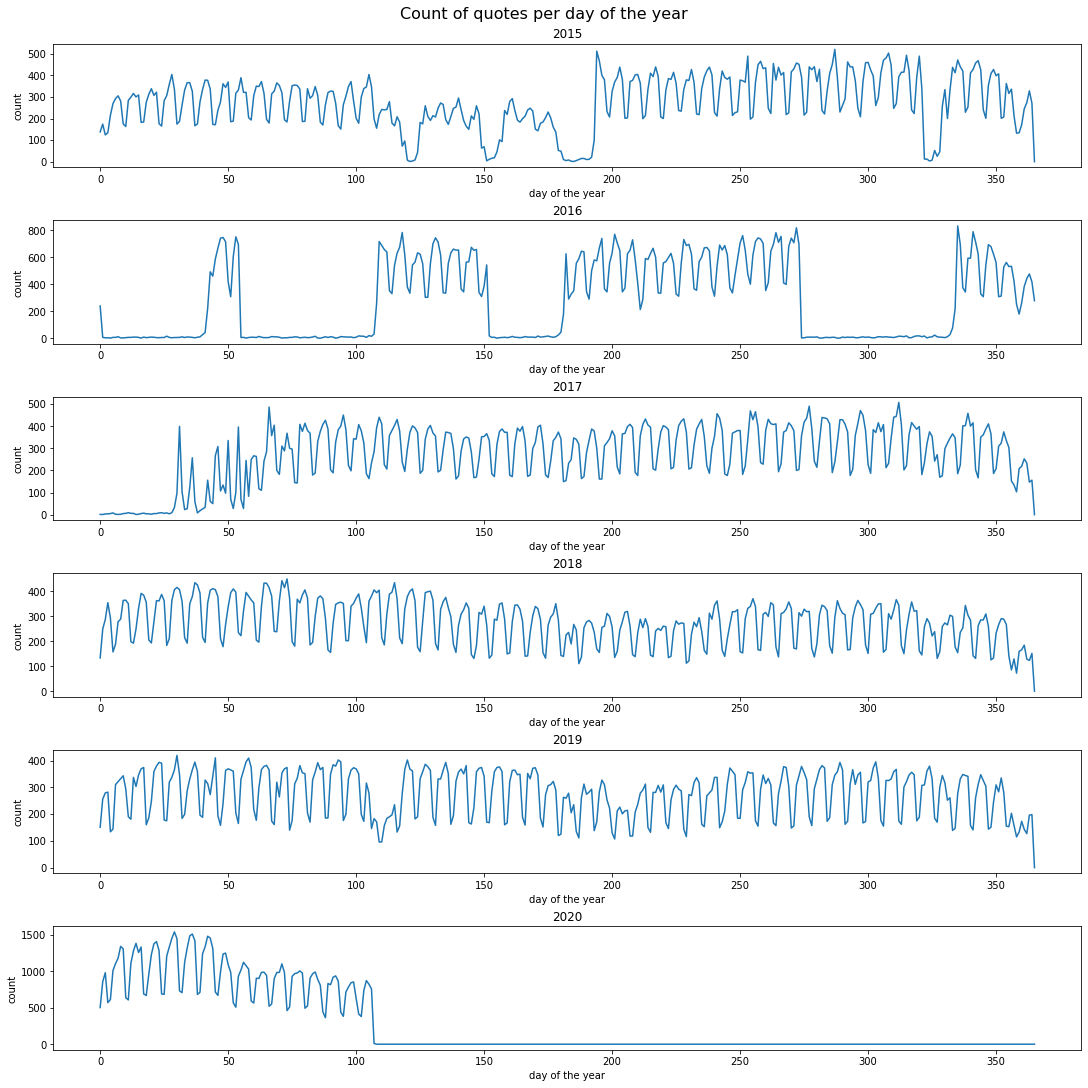

In [37]:
years = ['2015','2016','2017','2018','2019','2020']
day = np.arange(366)

(fig, axes) = plt.subplots(6, constrained_layout=True, figsize=(15, 15))
fig.suptitle('Count of quotes per day of the year', fontsize=16)

for (year, ax) in zip(years, axes):
    path_to_file = data_path+'Quotebank/quotes-{year}.json.bz2'.format(year=year)
    count_days = count_per_day(path_to_file, max_instances=100000)
    ax.plot(day, count_days)
    ax.set_title(year)
    ax.set_xlabel('day of the year')
    ax.set_ylabel('count')

plt.show()

When looking at the dates, we have to be careful about the number of quotations per day.

We see an obvious weekly tendency in the number of quotes and that for some reason, in 2020 the data stops at ~110 days. There's also some seemingly unexplicable drop in quotes.For example, the quotes from year 2016 do some strange time where the data is missing.

## NumOccurrences 

We want to grasp more how important is the numOccurrences feature. To do so, let's focus on its distribution. First, to know how big it can get, we find the maximum and the minimum to be sure we don't have any negative values:

In [38]:
min = 0
max = 0
count = 0
with bz2.open(data_path+'Quotebank/quotes-2020.json.bz2', "rb") as s_file:
    for instance in s_file:
        instance = json.loads(instance)  # loading a sample
        numOccurrences = instance["numOccurrences"]  # extracting the date
        if numOccurrences < min:
            min = numOccurrences
        if numOccurrences > max:
            max = numOccurrences
        count = 1

In [39]:
print(f'the min is {min}')
print(f'the max is {max}')

the min is 0
the max is 9210


We know have the range for the number of occurences and will see how they are distributed on an histogram:

In [40]:
count_Occurences = np.zeros((max + 1, ))

with bz2.open(data_path+'Quotebank/quotes-2020.json.bz2', 'rb') as s_file:
    for instance in s_file:
        instance = json.loads(instance)  # loading a sample
        numOccurrences = instance['numOccurrences']  # extracting the date
        count_Occurences[numOccurrences] += 1

9210


Text(0.5, 1.0, 'Distribution of the number of occurences for the quotes from 2019')

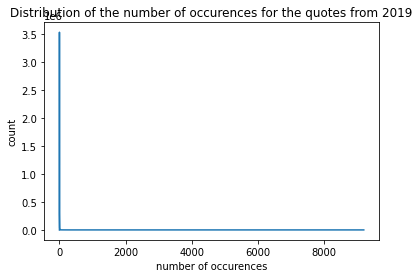

In [41]:
occurences = np.arange(max+1)
print(max)
plt.plot(occurences, count_Occurences)
plt.xlabel("number of occurences")
plt.ylabel("count")
plt.title("Distribution of the number of occurences for the quotes from 2019")

As expected, most of the number of occurences are quite low, thus not suited for linear scale. Let's plot it on a logarithmic scale

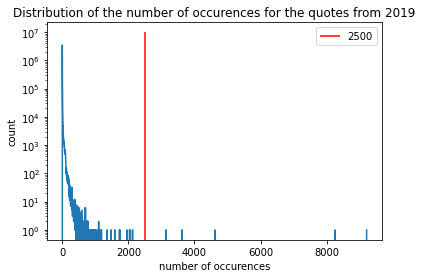

In [42]:
occurences = np.arange(max+1)
plt.plot(occurences, count_Occurences)
plt.xlabel("number of occurences")
plt.ylabel("count")
plt.yscale('log')
plt.title("Distribution of the number of occurences for the quotes from 2019")
plt.vlines(2500, 0, 9999999, colors='r', label = '2500')
plt.legend()

Most of the quotes appears a relatively small amount of time. However, it has a possible importance in our research.

There is also some clear outliers. We will focus on the number of occurences bigger than 2500.

In [43]:
enum = enumerate(count_Occurences)
dict_old = dict((i, j) for i,j in enum)

dict_new = { key: value for key, value in dict_old.items() if (key >2500 ) and (value > 0) }
print(dict_new)

{3133: 1.0, 3617: 1.0, 4624: 1.0, 8257: 1.0, 9210: 1.0}


We notice that for each of these outlier, we have only one quote with a number of occurence this high. Let's look at them to see if there's anything strange about them:

In [44]:
quotes_occurrences = []
with bz2.open(data_path+'Quotebank/quotes-2020.json.bz2', 'rb') as s_file:
    for instance in s_file:
        instance = json.loads(instance)  # loading a sample
        numOccurrences = instance['numOccurrences']  # extracting the numOccurrences
        for num_occ in dict_new.keys():
            if numOccurrences == num_occ:
                quotes_occurrences.append(instance)

In [73]:
quote = quotes_occurrences[2].get('quotation')
urls = quotes_occurrences[2].get('urls')
print(quote)
print(urls[0:15])

something we talk about a lot
['http://www.gamereactor.eu/?system=switch&sid=dd39141ee3db3e8e1308331b80210195', 'http://www.gamereactor.eu/?system=pc&sid=dd39141ee3db3e8e1308331b80210195', 'http://www.gamereactor.eu/?system=pc&sid=77038c39d19e12febffce16037b21b4b', 'http://www.gamereactor.eu/?system=3ds&sid=77038c39d19e12febffce16037b21b4b', 'http://www.gamereactor.eu/?system=ps4&sid=8152dfec63bbb3ae562a80f065144b37', 'http://www.gamereactor.eu/?system=ps3&sid=8152dfec63bbb3ae562a80f065144b37', 'http://www.gamereactor.eu/?system=3ds&sid=340c730296ac9db66b81622627e6347c', 'http://www.gamereactor.eu/?system=ps4&sid=340c730296ac9db66b81622627e6347c', 'http://www.gamereactor.eu/?system=switch&sid=340c730296ac9db66b81622627e6347c', 'http://www.gamereactor.eu/?system=pc&sid=340c730296ac9db66b81622627e6347c', 'http://www.gamereactor.eu/?system=pc&sid=377cdd4d914f1a6dad4ca255527ec97e', 'http://www.gamereactor.eu/?system=ps4&sid=377cdd4d914f1a6dad4ca255527ec97e', 'http://www.gamereactor.eu/?sys

When a quote has an unusual number of occurences, it is likely that all the occurences come from the same site. If we take the example with the most occurences (9210), we easily see in the 'urls' that they all seemingly come from the website gamereactor.

In [74]:

count = 0
count_gamereactor = 0
for url in urls:
    if url[11:22] == "gamereactor":
        count_gamereactor += 1
    count+=1

print(f'{count_gamereactor*100/count}% of the occurences from the quote: <{quote}> comes from the website gamereactor.')

100.0% of the occurences from the quote: <something we talk about a lot> comes from the website gamereactor.


Knowing this, we will have to take into account the importance of the number of occurences and be extremly carefull with the extreme cases. If 9210 different peoples use the same quotation 1 time, it weighs more than 1 people using it 9210 time.

## Speakers

To have a better understanding of the speakers, let's take a look at the distribution of the speaker. If there's some speaker that appears more often, it can be a sign of unblanced dataset. This is something that we have to take into account.

In [46]:
speakersID = set()
quotes = bz2.open(data_path+'Quotebank/quotes-2020.json.bz2', 'rb')
for q in quotes:
    quote = json.loads(q)
    speakers = quote['qids']
    for speakerID in speakers:
        speakersID.add(speakerID)

In [47]:
len(speakersID)

323074

In [48]:
dict_speaker = {}
with bz2.open(data_path+'Quotebank/quotes-2020.json.bz2', 'rb') as s_file:
    for instance in s_file:
        instance = json.loads(instance)  # loading a sample
        speaker = instance['speaker']  # extracting the speaker
        if speaker != 'None':
            if speaker in dict_speaker.keys():
                dict_speaker[speaker] += 1
            else:
                dict_speaker.update({speaker: 1})

In [49]:
sorted_dict_speaker = {key: value for key, value in sorted(dict_speaker.items(), key=lambda item: item[1], reverse= True)}

place = 1
for (speak, nbr) in list(sorted_dict_speaker.items())[:10]:
    print(f'{place}: {speak} with {nbr} quotes')
    place += 1

1: President Donald Trump with 28023 quotes
2: Bernie Sanders with 13189 quotes
3: Joe Biden with 12817 quotes
4: President Trump with 12415 quotes
5: Andrew Cuomo with 11088 quotes
6: Narendra Modi with 8239 quotes
7: Elizabeth Warren with 7647 quotes
8: Donald Trump with 7104 quotes
9: Boris Johnson with 6952 quotes
10: Scott Morrison with 6601 quotes


Withtout surprise, it is important personalities that we find in the top 10 of our speaker for the year 2020. We mostly see political candidates. There's multiple information we see from this top 10:   

There's duplicate in our speakers: Donald trump under different name appears at 3 different places: 1st with 'President Donald Trump', 4th with 'President Trump' and 8th with 'Donald Trump'. However, if they are correctly classified in our research, it shoudln't be a problem since we can identify all the aliases and group them under the same QID.

There's an obvious biais in the provenance of the quotation. 5 of the 8 most quoted people from the dataset are from the USAs: 

  *   Donald Trump: 45th U.S. President
  *   Bernie Sanders: United States Senator
  *   Joe Biden: 46th U.S. President
  *   Andrew Cuomo: Former Governor of New York
  *   Elizabeth Warren: United States Senator
  

And only 3 are from the rest of the world:


  *   Narendra Modi: Prime Minister of India
  *   Boris Jonhson: Prime Minister of the United Kingdom
  *   Scott Morrison: Prime Minister of Australia

 
Note that all of them are from politics. That means that when we are dealing with the 'speaker' feature, we have to be careful about the Data bias.

Below we look at the ~1% most quoted speakers. Then we look at the percentage of their combined number of quotes over the total number of quotes (minus the one without speakers, see the '_special case: when we need to have the speaker's information_' for the values _count_quote_ and _count_none_)

In [50]:
nbr_speakers = len(sorted_dict_speaker)
n = 2185 # Choice of n to make it the closest to 1%
print(f"Percentage of speaker: {n*100/nbr_speakers}")
sum = 0
for (k,v) in list(sorted_dict_speaker.items())[:n]:
    sum += v


print(f"Percentage of quotes:  {sum*100/(count_quote - count_none)}")

Percentage of speaker: 1.0003937476535387
Percentage of quotes:  32.43647282426411


We see that ~1% of the speakers were quoted for almost a third of the total number of quotations from recognized speaker. This add another Data bias to take into account.

# Preparing the data to pair speakers and their occupations

In [9]:
#Creating a list of all the occupation in speaker attributes
occup = []
for w in speaker_attributes['occupation'].dropna():
    for i in w:
        occup.append(i)
len(occup)

8340215

In [10]:
#Creating a dictionnary with the occupation as key and their number of occurences as value
occurence = {}
for i in occup:
    if i in occurence:
        occurence[i]=occurence[i]+1
    else:
        occurence[i]=1
len(occurence)

14575

In [11]:
label_description.head()

,Label,Description
QID,,
Q31,Belgium,country in western Europe
Q45,Portugal,country in southwestern Europe
Q75,Internet,global system of connected computer networks
Q148,People's Republic of China,sovereign state in East Asia
Q155,Brazil,country in South America


In [12]:
#Dropping the nan value in the dataset
lab_desc = label_description.reset_index().dropna()
lab_desc.head()

,QID,Label,Description
0,Q31,Belgium,country in western Europe
1,Q45,Portugal,country in southwestern Europe
2,Q75,Internet,global system of connected computer networks
3,Q148,People's Republic of China,sovereign state in East Asia
4,Q155,Brazil,country in South America


In [13]:
#Adding the occurences
dico = {}
for i in occurence:
    if i in lab_desc['QID'].values:
        dico[i]= [lab_desc[lab_desc['QID']==i]['Label'].values.item(),lab_desc[lab_desc['QID']==i]['Description'].values.item(),occurence[i]]
print(dico['Q82955'])

['politician', 'person involved in politics, person who holds or seeks positions in government', 658049]


In [14]:
#Creating the dataframe with id, label,description and the number of occurences
df_LD = pd.DataFrame(dico.items(), columns=['ID', 'Label'])
df_LD[['Label','Description','Occurences']] = pd.DataFrame(df_LD.Label.tolist(), index= df_LD.index)
df_LD.sort_values(by=['Occurences'],ascending=False)
df_LD.head()

,ID,Label,Description,Occurences
0,Q82955,politician,"person involved in politics, person who holds ...",658049
1,Q189290,military officer,member of an armed force or uniformed service ...,38841
2,Q131512,farmer,person who works in agriculture,10476
3,Q1734662,cartographer,person preparing geographical maps,2404
4,Q294126,land surveyor,profession,938


In [15]:
#Loading the dataset in a parquet file
#df_LD.to_parquet('data/Id_Work2.parquet')

### Clustering

Our aim is to cluster the label in order to ideally have a cluster regrouping all the medical field, the financial one, the ecology one, military, etc...
We will use the label and the description in order to find relevant cluster. We have tried different approaches, using TF_IDF matrix, word2vec, doc2vec and we encounter the same problem in all of them. Indeed doing that kind of clustering is actually a really complicated task, we always managed to find some relevant cluster for example the sports together, artist together but we always end up with cluster with no sens as there are too many different profession. We decided to focus on the TF_IDF approach which seemed to be working the best, after some tuning on the parameters we were able to find a good cluster regrouping the profession of the medical field and others about military, engineer,... Unfortunatly we were not able to have an economy or ecology cluster so we decided to look into a more brute force approach. Once the clustering was done, we regroup all the cluster that didn't make sens into one again and filter them in 3 cluster using list of words, one for economy one for ecology and the last one for those that didn't belong anywhere and didn't interested us, the trash cluster.

In [16]:
df_LD.head()

,ID,Label,Description,Occurences
0,Q82955,politician,"person involved in politics, person who holds ...",658049
1,Q189290,military officer,member of an armed force or uniformed service ...,38841
2,Q131512,farmer,person who works in agriculture,10476
3,Q1734662,cartographer,person preparing geographical maps,2404
4,Q294126,land surveyor,profession,938


In [17]:
texts_all = df_LD.Description # Extract description
target_all = df_LD.Label # Extract label
job_desc_all = target_all.str.cat(texts_all, sep=' , ') #Group the description and label together

In [33]:
vectorizer = TfidfVectorizer(stop_words='english',ngram_range=(1,3))
X = vectorizer.fit_transform(job_desc_all)

C:\Users\signe\Anaconda3\lib\site-packages\numpy\matrixlib\defmatrix.py:71: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


In [34]:
# param for our model : cluster 15, iter 500, init 10, random state 22
number_of_clusters = 15

model = KMeans(n_clusters=number_of_clusters, 
               init='k-means++', 
               max_iter=500, # Maximum number of iterations of the k-means algorithm for a single run.
               n_init=10,random_state=22)  # Number of time the k-means algorithm will be run with different centroid seeds. The final results will be the best output of n_init consecutive runs in terms of inertia.
model.fit(X)

KMeans(max_iter=500, n_clusters=15, random_state=22)

In [35]:
#Assign the cluster to the corresponding label in the dataset
lab = model.labels_
df_cluster = df_LD.copy()
df_cluster['cluster'] = lab
df_cluster.head(5)

,ID,Label,Description,Occurences,cluster
0,Q82955,politician,"person involved in politics, person who holds ...",658049,5
1,Q189290,military officer,member of an armed force or uniformed service ...,38841,3
2,Q131512,farmer,person who works in agriculture,10476,5
3,Q1734662,cartographer,person preparing geographical maps,2404,5
4,Q294126,land surveyor,profession,938,4


In [36]:
#Loading the dataset in a parquet file
#df_cluster.to_parquet('data/cluster.parquet')

In [37]:
#Show what kind of profession are in each cluster and the number of them
for i in range(number_of_clusters):
    print('--------------Cluster',i,'---------------')
    print(df_cluster[df_cluster['cluster']==i]['Label'])

--------------Cluster 0 ---------------
6             statesperson
7              slaveholder
9             screenwriter
10                novelist
11       children's writer
               ...        
9770          beauty salon
9772    mineral processing
9774         Meistersinger
9775           ethnography
9778         Fashion Model
Name: Label, Length: 5414, dtype: object
--------------Cluster 1 ---------------
372               professor
1536         Superintendent
1682       fashion designer
1689                  Blind
1745               Reformer
               ...         
9626             Mentaliste
9660    goodwill ambassador
9699                Harcerz
9707       Andalusian music
9777             Programmer
Name: Label, Length: 302, dtype: object
--------------Cluster 2 ---------------
32                  astronomer
33                      jurist
114                 theologian
127                  zoologist
128              carcinologist
                 ...          
9524    

In [38]:
#Here we show our medecine cluster
df_cluster[df_cluster['cluster']==7].sort_values(by=['Occurences'],ascending=False).head()

,ID,Label,Description,Occurences,cluster
39,Q39631,physician,professional who practices medicine,56180,7
221,Q774306,surgeon,physician with surgical specialty,8915,7
318,Q3368718,pathologist,physician with medical specialty pathology,1742,7
682,Q1919436,pediatrician,physician with medical specialty pediatrics,1739,7
606,Q15924224,internist,physician with medical specialty internal medi...,1721,7


In [39]:
#We define our list of words corresponding to the economy and ecology field
list_cluster = [3,6,7,9,10,14]
finance = ['revenue','business','economics','economy','money','investments','accountancy']
ecolo = ['ecology','environmental','environment','environmentalist','climat','pollution','green','ecologic','eco','sustainable']

In [40]:
#We assign the value 0 to all the unwanted cluster
df_cluster.loc[~df_cluster['cluster'].isin(list_cluster),'cluster']=0

In [41]:
df_cluster['cluster'].value_counts()

0     8557
6      480
14     258
3      183
7      117
9      100
10      84
Name: cluster, dtype: int64

In [42]:
#assign the value 1 for the economy cluster and value 2 to the ecology cluster
for index, row in df_cluster.iterrows():
    words = row['Label'].split()
    words = words + row['Description'].split()
    for w in words:
        if w in finance:
            df_cluster.loc[index,'cluster']=1
        if w in ecolo:
            df_cluster.loc[index,'cluster']=2

In [43]:
#rearrange the cluster in a nicest way
df_cluster.loc[df_cluster['cluster']==3,'cluster']=4
df_cluster.loc[df_cluster['cluster']==7,'cluster']=3
df_cluster.loc[df_cluster['cluster']==14,'cluster']=5
df_cluster.loc[df_cluster['cluster']==10,'cluster']=7
df_cluster.loc[df_cluster['cluster']==9,'cluster']=8

In [45]:
df_cluster['cluster'].value_counts()

0    8382
6     478
5     257
4     183
1     135
3     117
8      96
7      83
2      48
Name: cluster, dtype: int64

In [46]:
#Dictionnary to see which cluster correspond to what
cluster_name = {0:'trash',
               1:'economy',
               2:'ecology',
               3:'medecine',
               4:'military',
               5:'artist',
               6:'diplomat/official',
               7:'teacher',
               8:'engineer'}

In [47]:
#load the data in a parquet file for convenience
#df_good.to_parquet('data/clean_cluster.parquet')

In [48]:
df_cluster.head()

,ID,Label,Description,Occurences,cluster
0,Q82955,politician,"person involved in politics, person who holds ...",658049,0
1,Q189290,military officer,member of an armed force or uniformed service ...,38841,4
2,Q131512,farmer,person who works in agriculture,10476,0
3,Q1734662,cartographer,person preparing geographical maps,2404,0
4,Q294126,land surveyor,profession,938,0


In [51]:
cluster_occu = {}
for i in cluster_name:
    cluster_occu[i] = df_cluster[df_cluster['cluster']==i]['Occurences'].sum()
print(cluster_occu)    

{0: 7031749, 1: 128117, 2: 16333, 3: 78587, 4: 149718, 5: 630586, 6: 108551, 7: 70594, 8: 43129}


In [58]:
list(cluster_occu.values())

[7031749, 128117, 16333, 78587, 149718, 630586, 108551, 70594, 43129]

In [85]:
data = {'cluster':list(cluster_occu.keys()),
        'occu':list(cluster_occu.values()),'name':list(cluster_name.values())}
  
df_plot = pd.DataFrame(data)
#df_plot = df_plot.drop(0)
df_plot

,cluster,occu,name
0,0,7031749,trash
1,1,128117,economy
2,2,16333,ecology
3,3,78587,medecine
4,4,149718,military
5,5,630586,artist
6,6,108551,diplomat/official
7,7,70594,teacher
8,8,43129,engineer


Text(0.5, 1.0, 'Number of Occurences for each Cluster')

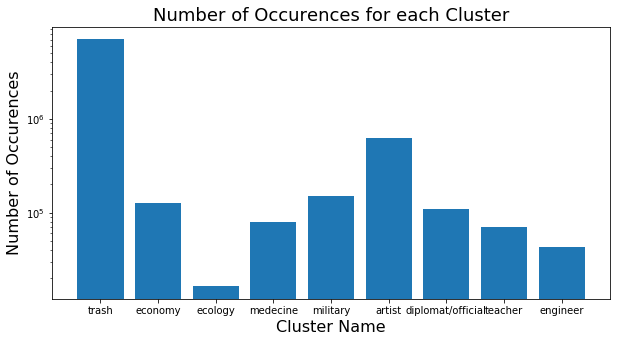

In [87]:
fig, ax = plt.subplots(figsize=(10,5))
plt.bar('name', 'occu',data=df_plot, log=True)
plt.xlabel("Cluster Name", size=16)
plt.ylabel("Number of Occurences", size=16)
plt.title("Number of Occurences for each Cluster", size=18)

# First approach of the sentiment analysis 

## Polarity scores of quotes using Vader

Here, we provide the method that allow us to compute the polarity scores using VaderSentiment as our first look for sentiment analysis of the quotes :

In [68]:
sid = SentimentIntensityAnalyzer()

path_to_file = data_path+'data/quotes-2020-dropped-features.json.bz2' 
path_to_out = 'data/quotes-2020-polarity-scores.json.bz2'

with bz2.open(path_to_file, 'rb') as s_file:
    with bz2.open(path_to_out, 'wb') as d_file:
        for instance in s_file:
            instance = json.loads(instance)
            quote = instance['quotation']
            scores = sid.polarity_scores(quote)
            instance['polarity_scores'] = scores
            #print(scores)
            d_file.write((json.dumps(instance)+'\n').encode('utf-8')) # writing in the new file